In [ ]:
#@title Data-AI（必ず自分の名前・学籍番号を入力すること） { run: "auto", display-mode: "form" }

import urllib.request as ur
import urllib.parse as up
Name = '\u5BB6\u5C3E\u702C \u4F0A\u52E2' #@param {type:"string"}
EName = 'Kaose Ise' #@param {type:"string"}
StudentID = '87654321' #@param {type:"string"}
Addrp = !cat /sys/class/net/eth0/address
Addr = Addrp[0]
url = 'https://class.west.sd.keio.ac.jp/classroll.php'
params = {'class':'dataai','name':Name,'ename':EName,'id':StudentID,'addr':Addr,
           'page':'dataai-text-G','token':'83750132'}
data = up.urlencode(params).encode('utf-8')
#headers = {'itmes','application/x-www-form-urlencoded'}
req = ur.Request(url, data=data)
res = ur.urlopen(req)

---
> 顔の悪いのが、なんで悪いんだ！！  
> のび太
---

# StyleGANで遊ぶ

既にStyleGAN2に加えて、StyleGAN3が登場し、PyTorchでも動作するようになった
- とはいえ、Colabで動作させるには様々準備が必要で、間に合っていない…

## 自分の顔、好きな顔で遊ぶ

StyleGANは、「人物の顔画像」を生成できるが、「狙った人物の顔画像」を作るには、「その顔画像を作り出す潜在空間」を求める必要がある
- そんなことができるのか？
  - 試してみるとよい
- すると自分の顔の年齢を変えたり、性別を変えたり、髪型変えたりできるのか？
  - 試してみるとよい
- どのような顔でも潜在空間表現が存在するのか？
  - 試してみるとよい

ここでは、すぐに試せるように、これまでと違ってGoogle Driveを使わずColab環境だけで試してみよう。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py", line 729, in _input_request
    ident, reply = self.session.recv(self.stdin_socket, 0)
  File "/usr/local/lib/python3.7/dist-packages/jupyter_client/session.py", line 803, in recv
    msg_list = socket.recv_multipart(mode, copy=copy)
  File "/usr/local/lib/python3.7/dist-packages/zmq/sugar/socket.py", line 625, in recv_multipart
    parts = [self.recv(flags, copy=copy, track=track)]
  File "zmq/backend/cython/socket.pyx", line 781, in zmq.backend.cython.socket.Socket.recv
  File "zmq/backend/cython/socket.pyx", line 817, in zmq.backend.cython.socket.Socket.recv
  File "zmq/backend/cython/socket.pyx", line 186, in zmq.backend.cython.socket._recv_copy
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/li

TypeError: ignored

In [ ]:
# Copyright (c) 2019, NVIDIA CORPORATION. All rights reserved.
#
# This work is licensed under the Creative Commons Attribution-NonCommercial
# 4.0 International License. To view a copy of this license, visit
# http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
# Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.


%tensorflow_version 1.x
%cd /content/
!git clone https://github.com/NVlabs/stylegan.git
%cd stylegan

import os
import sys
import math
import pickle
import imageio
import numpy as np
from PIL import Image
import tensorflow as tf
import moviepy.editor as mpy
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
import dnnlib
import dnnlib.tflib as tflib

from training import misc
import scipy.ndimage
import bz2
from keras.utils import get_file
import dlib

import argparse
import shutil
import dataset_tool
from training import dataset

%matplotlib inline

!rm -rf sample_data
!mkdir networks/other
vgg16 = 'vgg16_zhang_perceptual.pkl'
Gs = None
_cache = dict()
clear_output()


# Declare the necessary functions
def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
  
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")
     
def move_latent_and_save(latent_vector, direction, direction_file, coeffs, Gs_network, Gs_syn_kwargs):
    os.makedirs('results/'+direction_file.split('.')[0], exist_ok=True)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[0][:8] = (latent_vector[0] + coeff*direction)[:8]
        images = Gs_network.components.synthesis.run(new_latent_vector, **Gs_syn_kwargs)
        result = Image.fromarray(images[0], 'RGB')
        result.thumbnail(size, Image.ANTIALIAS)
        result.save('results/'+direction_file.split('.')[0]+'/'+str(i).zfill(3)+'.png')
        if len(coeffs)==1:
          return result

def image_align(src_file, dst_file, face_landmarks, output_size=1024, transform_size=4096, enable_padding=True):

    lm = np.array(face_landmarks)
    lm_chin          = lm[0  : 17]  # left-right
    lm_eyebrow_left  = lm[17 : 22]  # left-right
    lm_eyebrow_right = lm[22 : 27]  # left-right
    lm_nose          = lm[27 : 31]  # top-down
    lm_nostrils      = lm[31 : 36]  # top-down
    lm_eye_left      = lm[36 : 42]  # left-clockwise
    lm_eye_right     = lm[42 : 48]  # left-clockwise
    lm_mouth_outer   = lm[48 : 60]  # left-clockwise
    lm_mouth_inner   = lm[60 : 68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left     = np.mean(lm_eye_left, axis=0)
    eye_right    = np.mean(lm_eye_right, axis=0)
    eye_avg      = (eye_left + eye_right) * 0.5
    eye_to_eye   = eye_right - eye_left
    mouth_left   = lm_mouth_outer[0]
    mouth_right  = lm_mouth_outer[6]
    mouth_avg    = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2

    # Load raw image.
    if not os.path.isfile(src_file):
        print('Error 100')
        return
    img = Image.open(src_file)

    # Shrink.
    shrink = int(np.floor(qsize / output_size * 0.5))
    if shrink > 1:
        rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
        img = img.resize(rsize, Image.ANTIALIAS)
        quad /= shrink
        qsize /= shrink

    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        quad -= crop[0:2]

    # Pad.
    pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
    if enable_padding and max(pad) > border - 4:
        pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
        img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.ogrid[:h, :w, :1]
        mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
        blur = qsize * 0.02
        img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
        img = Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
        quad += pad[:2]

    # Transform.
    img = img.transform((transform_size, transform_size), Image.QUAD, (quad + 0.5).flatten(), Image.BILINEAR)
    if output_size < transform_size:
        img = img.resize((output_size, output_size), Image.ANTIALIAS)

    # Save aligned image.
    img.save(dst_file, 'PNG')


def load_networks(path_or_url_path):
    if path_or_url_path in _cache:
        return _cache[path_or_url_path]

    if dnnlib.util.is_url(path_or_url_path):
        stream = dnnlib.util.open_url(path_or_url_path, cache_dir='.stylegan2-cache')
    else:
        stream = open(path_or_url_path, 'rb')

    tflib.init_tf()
    with stream:
        G, D, Gs = pickle.load(stream, encoding='latin1')
    _cache[path_or_url_path] = G, D, Gs
    return G, D, Gs


class Projector:
    def __init__(self,
        vgg16_pkl                       = 'https://drive.google.com/uc?id=1N2-m9qszOeVC9Tq77WxsLnuWwOedQiD2',
        num_steps                       = 1000,
        initial_learning_rate           = 0.1,
        initial_noise_factor            = 0.05,
        verbose                         = False
    ):

        self.vgg16_pkl                  = vgg16_pkl
        self.num_steps                  = num_steps
        self.dlatent_avg_samples        = 10000
        self.initial_learning_rate      = initial_learning_rate
        self.initial_noise_factor       = initial_noise_factor
        self.lr_rampdown_length         = 0.25
        self.lr_rampup_length           = 0.05
        self.noise_ramp_length          = 0.75
        self.regularize_noise_weight    = 1e5
        self.verbose                    = verbose
        self.clone_net                  = True

        self._Gs                    = None
        self._minibatch_size        = None
        self._dlatent_avg           = None
        self._dlatent_std           = None
        self._noise_vars            = None
        self._noise_init_op         = None
        self._noise_normalize_op    = None
        self._dlatents_var          = None
        self._noise_in              = None
        self._dlatents_expr         = None
        self._images_expr           = None
        self._target_images_var     = None
        self._lpips                 = None
        self._dist                  = None
        self._loss                  = None
        self._reg_sizes             = None
        self._lrate_in              = None
        self._opt                   = None
        self._opt_step              = None
        self._cur_step              = None

    def _info(self, *args):
        if self.verbose:
            print('Projector:', *args)

    def set_network(self, Gs, minibatch_size=1):
        assert minibatch_size == 1
        self._Gs = Gs
        self._minibatch_size = minibatch_size
        if self._Gs is None:
            return
        if self.clone_net:
            self._Gs = self._Gs.clone()

        # Find dlatent stats.
        self._info('Finding W midpoint and stddev using %d samples...' % self.dlatent_avg_samples)
        latent_samples = np.random.RandomState(123).randn(self.dlatent_avg_samples, *self._Gs.input_shapes[0][1:])
        dlatent_samples = self._Gs.components.mapping.run(latent_samples, None) # [N, 18, 512]
        self._dlatent_avg = np.mean(dlatent_samples, axis=0, keepdims=True) # [1, 18, 512]
        self._dlatent_std = (np.sum((dlatent_samples - self._dlatent_avg) ** 2) / self.dlatent_avg_samples) ** 0.5
        self._info('std = %g' % self._dlatent_std)

        # Find noise inputs.
        self._info('Setting up noise inputs...')
        self._noise_vars = []
        noise_init_ops = []
        noise_normalize_ops = []
        while True:
            n = 'G_synthesis/noise%d' % len(self._noise_vars)
            if not n in self._Gs.vars:
                break
            v = self._Gs.vars[n]
            self._noise_vars.append(v)
            noise_init_ops.append(tf.assign(v, tf.random_normal(tf.shape(v), dtype=tf.float32)))
            noise_mean = tf.reduce_mean(v)
            noise_std = tf.reduce_mean((v - noise_mean)**2)**0.5
            noise_normalize_ops.append(tf.assign(v, (v - noise_mean) / noise_std))
            self._info(n, v)
        self._noise_init_op = tf.group(*noise_init_ops)
        self._noise_normalize_op = tf.group(*noise_normalize_ops)

        # Image output graph.
        self._info('Building image output graph...')
        self._dlatents_var = tf.Variable(tf.zeros([self._minibatch_size] + list(self._dlatent_avg.shape[1:])), name='dlatents_var')
        self._noise_in = tf.placeholder(tf.float32, [], name='noise_in')
        dlatents_noise = tf.random.normal(shape=self._dlatents_var.shape) * self._noise_in
        self._dlatents_expr = self._dlatents_var + dlatents_noise
        self._images_expr = self._Gs.components.synthesis.get_output_for(self._dlatents_expr, randomize_noise=False)

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        proc_images_expr = (self._images_expr + 1) * (255 / 2)
        sh = proc_images_expr.shape.as_list()
        if sh[2] > 256:
            factor = sh[2] // 256
            proc_images_expr = tf.reduce_mean(tf.reshape(proc_images_expr, [-1, sh[1], sh[2] // factor, factor, sh[2] // factor, factor]), axis=[3,5])

        # Loss graph.
        self._info('Building loss graph...')
        self._target_images_var = tf.Variable(tf.zeros(proc_images_expr.shape), name='target_images_var')
        if self._lpips is None:
            self._lpips = misc.load_pkl(self.vgg16_pkl) # vgg16_zhang_perceptual.pkl
        self._dist = self._lpips.get_output_for(proc_images_expr, self._target_images_var)
        self._loss = tf.reduce_sum(self._dist)

        # Noise regularization graph.
        self._info('Building noise regularization graph...')
        reg_loss = 0.0
        for v in self._noise_vars:
            sz = v.shape[2]
            while True:
                reg_loss += tf.reduce_mean(v * tf.roll(v, shift=1, axis=3))**2 + tf.reduce_mean(v * tf.roll(v, shift=1, axis=2))**2
                if sz <= 8:
                    break # Small enough already
                v = tf.reshape(v, [1, 1, sz//2, 2, sz//2, 2]) # Downscale
                v = tf.reduce_mean(v, axis=[3, 5])
                sz = sz // 2
        self._loss += reg_loss * self.regularize_noise_weight

        # Optimizer.
        self._info('Setting up optimizer...')
        self._lrate_in = tf.placeholder(tf.float32, [], name='lrate_in')
        self._opt = dnnlib.tflib.Optimizer(learning_rate=self._lrate_in)
        self._opt.register_gradients(self._loss, [self._dlatents_var] + self._noise_vars)
        self._opt_step = self._opt.apply_updates()

    def run(self, target_images):
        # Run to completion.
        self.start(target_images)
        while self._cur_step < self.num_steps:
            self.step()

        # Collect results.
        pres = dnnlib.EasyDict()
        pres.dlatents = self.get_dlatents()
        pres.noises = self.get_noises()
        pres.images = self.get_images()
        return pres

    def start(self, target_images):
        assert self._Gs is not None

        # Prepare target images.
        self._info('Preparing target images...')
        target_images = np.asarray(target_images, dtype='float32')
        target_images = (target_images + 1) * (255 / 2)
        sh = target_images.shape
        assert sh[0] == self._minibatch_size
        if sh[2] > self._target_images_var.shape[2]:
            factor = sh[2] // self._target_images_var.shape[2]
            target_images = np.reshape(target_images, [-1, sh[1], sh[2] // factor, factor, sh[3] // factor, factor]).mean((3, 5))

        # Initialize optimization state.
        self._info('Initializing optimization state...')
        tflib.set_vars({self._target_images_var: target_images, self._dlatents_var: np.tile(self._dlatent_avg, [self._minibatch_size, 1, 1])})
        tflib.run(self._noise_init_op)
        self._opt.reset_optimizer_state()
        self._cur_step = 0

    def step(self):
        assert self._cur_step is not None
        if self._cur_step >= self.num_steps:
            return
        if self._cur_step == 0:
            self._info('Running...')

        # Hyperparameters.
        t = self._cur_step / self.num_steps
        noise_strength = self._dlatent_std * self.initial_noise_factor * max(0.0, 1.0 - t / self.noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / self.lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / self.lr_rampup_length)
        learning_rate = self.initial_learning_rate * lr_ramp

        # Train.
        feed_dict = {self._noise_in: noise_strength, self._lrate_in: learning_rate}
        _, dist_value, loss_value = tflib.run([self._opt_step, self._dist, self._loss], feed_dict)
        tflib.run(self._noise_normalize_op)

        # Print status.
        self._cur_step += 1
        if self._cur_step == self.num_steps or self._cur_step % 10 == 0:
            self._info('%-8d%-12g%-12g' % (self._cur_step, dist_value, loss_value))
        if self._cur_step == self.num_steps:
            self._info('Done.')

    def get_cur_step(self):
        return self._cur_step

    def get_dlatents(self):
        return tflib.run(self._dlatents_expr, {self._noise_in: 0})

    def get_noises(self):
        return tflib.run(self._noise_vars)

    def get_images(self):
        return tflib.run(self._images_expr, {self._noise_in: 0})


def project_image(proj, src_file, dst_dir, tmp_dir, video=False):
    data_dir = '%s/dataset' % tmp_dir
    if os.path.exists(data_dir):
        shutil.rmtree(data_dir)
    image_dir = '%s/images' % data_dir
    tfrecord_dir = '%s/tfrecords' % data_dir
    os.makedirs(image_dir, exist_ok=True)
    shutil.copy(src_file, image_dir + '/')
    dataset_tool.create_from_images(tfrecord_dir, image_dir, shuffle=0)
    dataset_obj = dataset.load_dataset(
        data_dir=data_dir, tfrecord_dir='tfrecords',
        max_label_size=0, repeat=False, shuffle_mb=0
    )

    print('Projecting image "%s"...' % os.path.basename(src_file))
    images, _labels = dataset_obj.get_minibatch_np(1)
    images = misc.adjust_dynamic_range(images, [0, 255], [-1, 1])
    proj.start(images)
    if video:
        video_dir = '%s/video' % tmp_dir
        os.makedirs(video_dir, exist_ok=True)
    while proj.get_cur_step() < proj.num_steps:
        print('\r%d / %d ... ' % (proj.get_cur_step(), proj.num_steps), end='', flush=True)
        proj.step()
        if video:
            filename = '%s/%08d.png' % (video_dir, proj.get_cur_step())
            misc.save_image_grid(proj.get_images(), filename, drange=[-1,1])
    print('\r%-30s\r' % '', end='', flush=True)

    os.makedirs(dst_dir, exist_ok=True)
    filename = os.path.join(dst_dir, os.path.basename(src_file)[:-4] + '.png')
    misc.save_image_grid(proj.get_images(), filename, drange=[-1,1])
    filename = os.path.join(dst_dir, os.path.basename(src_file)[:-4] + '.npy')
    np.save(filename, proj.get_dlatents()[0])


def render_video(src_file, dst_dir, tmp_dir, num_frames, mode, size, fps, codec, bitrate):

    def render_frame(t):
        frame = np.clip(np.ceil(t * fps), 1, num_frames)
        image = Image.open('%s/video/%08d.png' % (tmp_dir, frame))
        if mode == 1:
            canvas = image
        else:
            canvas = Image.new('RGB', (2 * src_size, src_size))
            canvas.paste(src_image, (0, 0))
            canvas.paste(image, (src_size, 0))
        if size != src_size:
            canvas = canvas.resize((mode * size, size), Image.LANCZOS)
        return np.array(canvas)

    src_image = Image.open(src_file)
    src_size = src_image.size[1]
    duration = num_frames / fps
    filename = os.path.join(dst_dir, os.path.basename(src_file)[:-4] + '.mp4')
    video_clip = mpy.VideoClip(render_frame, duration=duration)
    video_clip.write_videofile(filename, fps=fps, codec=codec, bitrate=bitrate)


def project_images(src_dir, dst_dir, vgg16_pkl=None, initial_learning_rate=None, network_pkl=None, initial_noise_factor=None,verbose=None, video=None, num_steps=10):

    global Gs

    tmp_dir = '.stylegan2-tmp'
    video_mode = 1
    video_size = 512
    video_fps = 25
    video_codec = 'libx264'
    video_bitrate = '3M'

    print('Loading networks from "%s"...' % network_pkl)
    _G, _D, Gs = load_networks(network_pkl)
    proj = Projector(
        vgg16_pkl             = vgg16_pkl,
        num_steps             = num_steps,
        initial_learning_rate = initial_learning_rate,
        initial_noise_factor  = 0.05,
        verbose               = verbose
    )
    proj.set_network(Gs)

    src_files = sorted([os.path.join(src_dir, f) for f in os.listdir(src_dir) if f[0] not in '._'])
    for src_file in src_files:
        project_image(proj, src_file, dst_dir, tmp_dir, video=video)
        if video:
            render_video(
                src_file, dst_dir, tmp_dir, num_steps, video_mode,
                video_size, video_fps, video_codec, video_bitrate
            )
        shutil.rmtree(tmp_dir)


In [ ]:
import os
if not os.path.exists('karras2019stylegan-ffhq-1024x1024.pkl'):
  !wget https://keio.box.com/shared/static/5b8x3nobo91doce8u0q46ze5j5fsy1np -O karras2019stylegan-ffhq-1024x1024.pkl

--2021-12-07 02:36:01--  https://keio.box.com/shared/static/5b8x3nobo91doce8u0q46ze5j5fsy1np
Resolving keio.box.com (keio.box.com)... 107.152.24.197
Connecting to keio.box.com (keio.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/5b8x3nobo91doce8u0q46ze5j5fsy1np [following]
--2021-12-07 02:36:02--  https://keio.box.com/public/static/5b8x3nobo91doce8u0q46ze5j5fsy1np
Reusing existing connection to keio.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://keio.app.box.com/public/static/5b8x3nobo91doce8u0q46ze5j5fsy1np [following]
--2021-12-07 02:36:02--  https://keio.app.box.com/public/static/5b8x3nobo91doce8u0q46ze5j5fsy1np
Resolving keio.app.box.com (keio.app.box.com)... 107.152.24.201
Connecting to keio.app.box.com (keio.app.box.com)|107.152.24.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b1!afHVc

In [ ]:
import os
if not os.path.exists('latent_directions.zip'):
  !wget https://keio.box.com/shared/static/jyhbj622xs3f75cw0n2hs4ygg7mv7ixy -O latent_directions.zip
  !unzip latent_directions.zip

--2021-12-07 02:45:58--  https://keio.box.com/shared/static/jyhbj622xs3f75cw0n2hs4ygg7mv7ixy
Resolving keio.box.com (keio.box.com)... 107.152.24.197
Connecting to keio.box.com (keio.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/jyhbj622xs3f75cw0n2hs4ygg7mv7ixy [following]
--2021-12-07 02:45:58--  https://keio.box.com/public/static/jyhbj622xs3f75cw0n2hs4ygg7mv7ixy
Reusing existing connection to keio.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://keio.app.box.com/public/static/jyhbj622xs3f75cw0n2hs4ygg7mv7ixy [following]
--2021-12-07 02:45:58--  https://keio.app.box.com/public/static/jyhbj622xs3f75cw0n2hs4ygg7mv7ixy
Resolving keio.app.box.com (keio.app.box.com)... 107.152.24.201
Connecting to keio.app.box.com (keio.app.box.com)|107.152.24.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b1!NgFDf

顔画像の保存フォルダを準備する

場所は、`/content/stylegan/raw_images`である

次のセルを実行すると画像ファイルの削除も行うので気を付けること

In [ ]:
!rm -rf raw_images/
!mkdir raw_images/


サンプル顔画像を使う場合

自分の顔や、特に誰かの顔画像を持ち合わせていないという場合は、次のセルを使って適当な顔画像を選ぶとよい。

1行目のphoto_sampleをsample_001,sample_002,sample_003,sample_004,sample_005,sample_006,sample_007から選んで実行する

お勧めは自分の顔画像で実行することだが、その場合はこのセルを実行せず次のセルを実行する


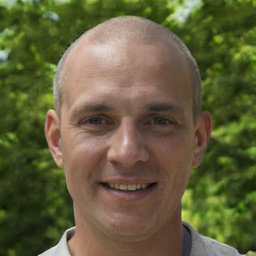

In [ ]:
photo_sample = 'sample_001'

urls = {}
# Urls after making shared link.
urls['sample_001'] = 'https://lh3.googleusercontent.com/pw/ACtC-3c0ApW2UaiyOBJ7iI9AvV-2AxWhz3VH3_chuyEJmqKjKJOLmr0XuqhT6GkP8AVUHOYOmqDkmWNZZU8LtSEE4ZUFduHOPF4DbXbJ8_GlFliTVGe5a0TsdZJvqi9YFUVZzpnGa89fy2yCz3RTB11CZ7WP=s512-no?authuser=0'
urls['sample_002'] = 'https://lh3.googleusercontent.com/pw/ACtC-3fyHsfjB8o2IJ4h9p3OJRxHKFdBxc_fju4VtfrSUxOQfYbunf_saeap0dyFKLrBTu3p1f4NdU4wz0YmE-g8keRQ6erK3xghBXAq3b03Fxx4NYYcf-VdNKkf1dUer6hPLY1b_oHj_hSKMKGcugyYbaJt=s512-no?authuser=0'
urls['sample_003'] = 'https://lh3.googleusercontent.com/pw/ACtC-3d2XTzgcqJ4FPndcKixqCi4qVcW7E1hM1UOtr2GNDKkz4IImsCXPSKUIHIdBJMywZqzcnC2NojAjL4VNQqgeIQwTP3oTC4KooRYCRXUWOiLszx9QwJoZV4WGrYC3tV-uOuiVZlEeKuR6VM603HCmkYX=s512-no?authuser=0'
urls['sample_004'] = 'https://lh3.googleusercontent.com/pw/ACtC-3f8qBcQYjjTpTwuCpntQImhxdgyU3W8waIVqk6sX6_h8fexWlTy9eu7l7gQkOuvh5rVIUC-9rjz7GRGeUTmIFqP9F45OcF1aUzp6yMx8A2ALjOF9LgqvkoCn6J7cGlVyUivYC7oDrZAgmiT_3yFdn5x=w1184-h789-no?authuser=0'
urls['sample_005'] = 'https://lh3.googleusercontent.com/pw/ACtC-3eQccyPYBZvk8hHkJWwuCvQYoss_hrNZBEKGhJcp78F9HqYFVOATf7jwtcowBtE0tRgGmH4koxH0PL_Ddzsn7TncHW0AKI2nFKcmGOBYvyrWRHtdE5o2ge8D5Y1N5-dl3qG_Vc0ZX2LY5jfwhvtsdEO=w527-h789-no?authuser=0'
urls['sample_006'] = 'https://lh3.googleusercontent.com/pw/ACtC-3eV-ZEoNTZdR1vgppQ8alzosnzTeJMCHkwoetiX_tncDidha7TSlxbzHZZKEfo5TgxhxFJp0FSFyED0PFopgDSi-qGAp9d6uDWP7ksJnPBFYqpBrTzzvt830HSU9aY_tlDzt9wOPcsJDl17PsICoa-a=w565-h852-no?authuser=0'
urls['sample_007'] = 'https://lh3.googleusercontent.com/pw/ACtC-3f3_N_zZHfuz3YXfc2_hoUHvIIrukUj5dXzyK_EaDITK5I2ctQ_Ba-Ghsz-4CqDewmYzkkA_IF7ZbQ_2hNzj-XFlVWlYyv78JPdiTBXmb-9gx7aAjD55I2jzF2osEZwPOF3CrgJB_R2dFFGO9IshmYO=w1184-h789-no?authuser=0'
urls['sample_008'] = 'https://lh3.googleusercontent.com/pw/ACtC-3cTURC9DU7znwOFipvCONQ0gM9KdguZb3QRV2y0vBNQStm0SVbjus_YRL0lG_bvGDV3iqUXgMxLXhlljzmGp0oiGyV_3MrwAAqEc1OQQmmaR2nbCFVC4pUOezjo2mApkZiKtuYy-XntqGybahkOcDHF=w450-h600-no?authuser=0'
urls['sample_009'] = 'https://lh3.googleusercontent.com/pw/ACtC-3e0-k3IVEGgqdfCpkADKNg0ImlfA_F5x1Sb-s8aEBYut1fCWLES51lxybNuMASF_2hD3uaJfk2WUJkmDYbocabhCKGfL2m9Fxs9VPQvS0G4buEyytCHCWSL-7b0_tWd07P1D5vMDwQGkPYrmI6tXEEd=w526-h789-no?authuser=0'
urls['sample_010'] = 'https://lh3.googleusercontent.com/pw/ACtC-3fV8SvPgJo8oNwF5sHkPIOk-GYHaCvejq7P_XQGFnN3FFf5oTfz6eLE_0EAcEmWigepjmOnVc8jnV7YRKIAfCKKgc5GhlPe7PVX6aKk91ng8RwPrY671-PyzrUYfHHxsIumb3sC10Tuex6q5cKnKkFF=w527-h789-no?authuser=0'
url = urls[photo_sample]

!wget $url
fp = url.split('/')[-1]

os.rename(fp, fp.replace(" ", ""))
fp = fp.replace(" ", "")
fn = 'photo.'+ fp.split('.')[-1]
!mv $fp raw_images/$fn
clear_output()

img1 = Image.open('raw_images/'+fn)
wpercent = (256/float(img1.size[0]))
hsize = int((float(img1.size[1])*float(wpercent)))
img1 = img1.resize((256,hsize), Image.LANCZOS)
display(img1)

独自の顔画像

`/content/stylegan/raw_images`に写真ファイルを配置する

1行目にファイル名を指定する
- ファイル名はphoto.pngとしておくこと
- pngファイルしか受け付けないので事前に変換しておく

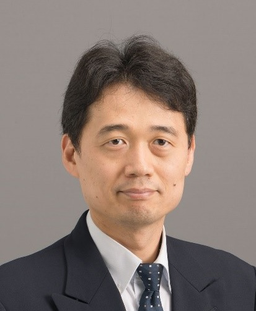

In [ ]:
uploades_file_path = 'photo.png'

fp = uploades_file_path
fp = fp.replace(" ", "")
fn = 'photo.'+ fp.split('.')[-1]
!cp $fp raw_images/$fn
clear_output()

img1 = Image.open('raw_images/'+fn)
wpercent = (256/float(img1.size[0]))
hsize = int((float(img1.size[1])*float(wpercent)))
img1 = img1.resize((256,hsize), Image.LANCZOS)
display(img1)

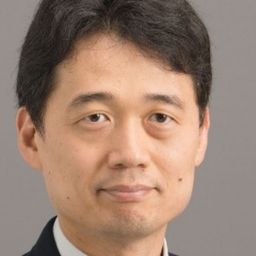

In [ ]:
!rm -rf aligned_images/
!mkdir aligned_images/
LANDMARKS_MODEL_URL = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'

def unpack_bz2(src_path):
    data = bz2.BZ2File(src_path).read()
    dst_path = src_path[:-4]
    with open(dst_path, 'wb') as fp:
        fp.write(data)
    return dst_path


class LandmarksDetector:
    def __init__(self, predictor_model_path):
        self.detector = dlib.get_frontal_face_detector() 
        self.shape_predictor = dlib.shape_predictor(predictor_model_path)

    def get_landmarks(self, image):
        img = dlib.load_rgb_image(image)
        dets = self.detector(img, 1)

        for detection in dets:
            face_landmarks = [(item.x, item.y) for item in self.shape_predictor(img, detection).parts()]
            yield face_landmarks

# Face cut
landmarks_model_path = unpack_bz2(get_file('shape_predictor_68_face_landmarks.dat.bz2',
                                            LANDMARKS_MODEL_URL, cache_subdir='temp'))
RAW_IMAGES_DIR = "raw_images"
ALIGNED_IMAGES_DIR = "aligned_images"
landmarks_detector = LandmarksDetector(landmarks_model_path)

for img_name in os.listdir(RAW_IMAGES_DIR):
    raw_img_path = os.path.join(RAW_IMAGES_DIR, img_name)
    for i, face_landmarks in enumerate(landmarks_detector.get_landmarks(raw_img_path), start=1):
        face_img_name = '%s_%02d.png' % (os.path.splitext(img_name)[0], i)
        aligned_face_path = os.path.join(ALIGNED_IMAGES_DIR, face_img_name)
        image_align(raw_img_path, aligned_face_path, face_landmarks)

align_images = !ls aligned_images
clear_output()
for align_image in align_images:
  display(Image.open('aligned_images/'+align_image).resize((256,256)))

In [ ]:
network_path = 'karras2019stylegan-ffhq-1024x1024.pkl'
iterat = 1500
learning_rate = 0.13

project_images('aligned_images/', 
                'generated_images/', 
                vgg16_pkl='https://drive.google.com/uc?id=1pWacZXNZnEV4ryiebW5XpIJ5EpfeKCS3', 
                num_steps=iterat, 
                initial_learning_rate=learning_rate,
                network_pkl=network_path,
                video=False)

!mkdir -p latent_representations/
vector_name = align_image.split('.')[0]+'.npy'
!mv generated_images/$vector_name latent_representations/$vector_name

fn = !ls latent_representations

Loading networks from "karras2019stylegan-ffhq-1024x1024.pkl"...



Loading images from ".stylegan2-tmp/dataset/images"
Creating dataset ".stylegan2-tmp/dataset/tfrecords"



Added 1 images.


Projecting image "photo_01.png"...


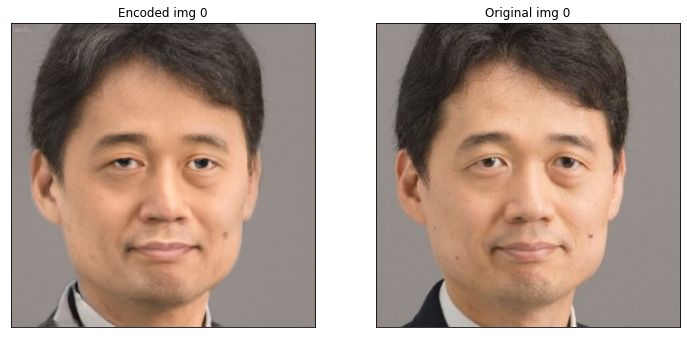

In [ ]:
display_sbs('generated_images/', 'aligned_images/', res = 512)

In [ ]:
base_path_directions = "/content/stylegan/latent_directions"
direction_gender = np.load(os.path.join(base_path_directions, 'direction_gender.npy'))
direction_glasses_ReadingGlasses = np.load(os.path.join(base_path_directions, 'direction_glasses_ReadingGlasses.npy'))
direction_glasses_SunGlasses = np.load(os.path.join(base_path_directions, 'direction_glasses_SunGlasses.npy'))
direction_glasses_NoGlasses = np.load(os.path.join(base_path_directions, 'direction_glasses_NoGlasses.npy'))
direction_hair_bald_0 = np.load(os.path.join(base_path_directions, 'direction_hair_bald_0.npy'))
direction_hair_bald_100 = np.load(os.path.join(base_path_directions, 'direction_hair_bald_100.npy'))
direction_facialHair = np.load(os.path.join(base_path_directions, 'direction_facialHair.npy'))

latent_directions = {}
latent_directions['gender'] = direction_gender
latent_directions['ReadingGlasses'] = direction_glasses_ReadingGlasses
latent_directions['SunGlasses'] = direction_glasses_SunGlasses
latent_directions['hair_0'] = direction_hair_bald_0
latent_directions['hair_100'] = direction_hair_bald_100
latent_directions['facialHair'] = direction_facialHair



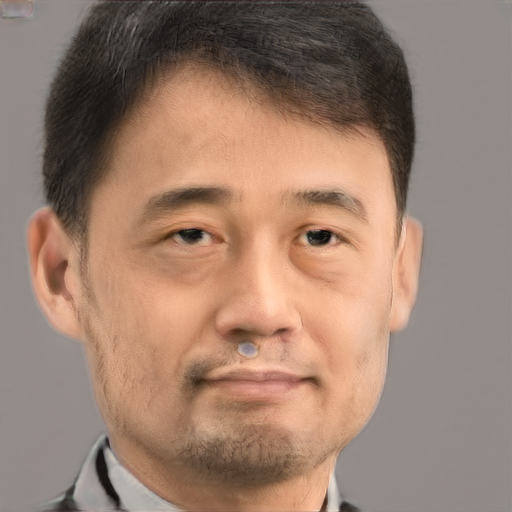

In [ ]:
#@title #**Modify face vector** { run: "auto", display-mode: "form" }
direction_selector = "gender" #@param ["gender", "ReadingGlasses","SunGlasses","hair_0","hair_100", "facialHair"]
direction = latent_directions[direction_selector]

w_avg = Gs.get_var('dlatent_avg')
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = 1

v = np.load('latent_representations/'+fn[0])
v = np.array([v])

coeffs = 9.9 #@param {type:"slider", min:-10, max:10, step:0.1}
coeffs = [coeffs]

resolution = "512" #@param [128, 256, 512, 1024]
size = int(resolution), int(resolution)
direction_name ="test"
move_latent_and_save( v, direction, direction_name, coeffs, Gs, Gs_syn_kwargs)

In [ ]:
#@title Animation
!rm -rf results/$direction_name

start_intensity = -29 #@param {type:"slider", min:-30, max:30, step:0.2}
end_intensity = 19.2 #@param {type:"slider", min:-20, max:20, step:0.2}
frames = 41 #@param {type:"slider", min:10, max:100, step:1}

duration = abs(start_intensity)+abs(end_intensity)
steps = round(duration/frames,2)
coeffs = []
resolution = "512" #@param [128, 256, 512, 1024]

if end_intensity > start_intensity:

  for i in range(int(start_intensity*100), int(end_intensity*100), int(steps*100)):
    coeffs.append(i/100)

  size = int(resolution), int(resolution)

  move_latent_and_save(v, direction ,direction_name, coeffs, Gs, Gs_syn_kwargs)

  reverse = True
  face_img = []
  img = os.listdir("results/"+direction_name)
  img.sort()
  for i in img:
    face_img.append(imageio.imread("results/" + direction_name + "/"+i))
  if reverse == True:
    for j in reversed(face_img):
      face_img.append(j)
  face_img = np.array(face_img)

  imageio.mimsave("results/test.mp4", face_img)
  display(mpy.ipython_display("results/test.mp4", height=400, autoplay=1, loop=1))

else:

  for i in range(int(end_intensity*100), int(start_intensity*100), int(steps*100)):
    coeffs.append(i/100)

  size = int(resolution), int(resolution)

  move_latent_and_save(v, direction ,direction_name, coeffs, Gs, Gs_syn_kwargs)

  reverse = True
  face_img = []
  img = os.listdir("results/"+direction_name)
  img.sort()
  for i in img:
    face_img.append(imageio.imread("results/" + direction_name + "/"+i))
  if reverse == True:
    for j in reversed(face_img):
      face_img.append(j)
  face_img = np.array(face_img)

  imageio.mimsave("results/test.mp4", face_img)
  display(mpy.ipython_display("results/test.mp4", height=400, autoplay=1, loop=1))
